## Notebook for anlyzing simulated data
Useful for testing visualizations for `cycling_rnn_plotter.py`

In [308]:
param_grid = {}
param_grid['activation'] = ['tanh', 'linear']
param_grid['beta1'] = np.concatenate((np.array([0]), np.logspace(-7, -2, 21)), axis=0)
param_grid['beta2'] = np.concatenate((np.array([0]), np.logspace(-5, 0, 21)), axis=0)
param_grid['stddev_state'] = np.concatenate((np.array([0]), np.logspace(-5, 0, 21)), axis=0)
param_grid['stddev_out'] = np.concatenate((np.array([0]), np.logspace(-4, 1, 21)), axis=0)
param_grid['monkey'] =['D']
param_grid['num_neurons'] = np.concatenate((np.array([100]).astype(int), np.round(np.logspace(1, 3, 21)).astype(int)), axis=0)

val_lengths = [len(v) for k, v in sorted(param_grid.items())]

# Make a copy of param_grid to export to matlab.
param_grid_matlab = copy.deepcopy(param_grid)
param_grid_matlab['val_lengths'] = val_lengths
param_grid_matlab['sorted'] = sorted(param_grid)

# val_lengths ordered by keys
# Important: apparently ParameterGrid() orders lexicographically based on keys.

# Split param_grid to search along hyperparameter axes only
param_grid = parameter_grid_split(param_grid)
len(ParameterGrid(param_grid))

107

In [85]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
import numpy as np
import scipy.io as sio
import sklearn as sk
from sklearn.grid_search import ParameterGrid
from sklearn import decomposition
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import datetime
import pickle
import os
import pprint
from cycling_rnn import *

## Plot settings

In [87]:
cmap = sns.color_palette('RdBu',5)[:2] + sns.color_palette('RdBu',5)[-2:]
sns.set_palette(cmap)
sns.set_context('paper', font_scale=1.5)

### Load stuff

In [113]:
RUN = './saves/8-27/'
param_grid = pickle.load(open(RUN+'npsaves/param_grid.pickle', 'rb'))

In [114]:
val_lengths = []
for p in range(len(param_grid)):
    val_lengths.append([len(v) for k, v in sorted(param_grid[p].items())])
val_lengths

[[1, 1, 1, 1, 1, 1, 1],
 [1, 12, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 13, 1, 1],
 [1, 1, 1, 1, 1, 12, 1],
 [1, 1, 1, 1, 1, 1, 1],
 [1, 1, 12, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 12]]

In [115]:
cum_lengths = np.cumsum([np.prod(val_lengths[p]) for p in range(len(val_lengths))])
print cum_lengths-1

[ 0 12 25 37 38 50 62]


In [116]:
keys = sorted(param_grid[0].keys())
keys

['activation',
 'beta1',
 'beta2',
 'monkey',
 'num_neurons',
 'stddev_out',
 'stddev_state']

In [117]:
sim = 0
cur_params = ParameterGrid(param_grid)[sim]
cur_params

{'activation': 'tanh',
 'beta1': 0.0001,
 'beta2': 0.0001,
 'monkey': 'D',
 'num_neurons': 100,
 'stddev_out': 0.0001,
 'stddev_state': 0.0001}

In [118]:
# List directory
# Number of sims in RUN
total_sims = len(os.listdir(RUN+'tb'))

# load x and y data
x = np.load(RUN+'npsaves/'+str(sim)+'x.npy')
y = np.load(RUN+'npsaves/'+str(sim)+'y.npy')
#os.listdir(RUN+'npsaves')

cur_params = ParameterGrid(param_grid)[sim]

In [119]:
if cur_params['monkey']=='D':
    data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/drakeFeb_processed.mat')
else:
    data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/cousFeb_processed.mat')
    
emg = data['EMG']
m1 = data['M1']

x = x[:emg.shape[0], :emg.shape[1], :]
y = y[:emg.shape[0], :emg.shape[1], :]

In [121]:
emg.shape

(80, 4, 36)

### plot stuff

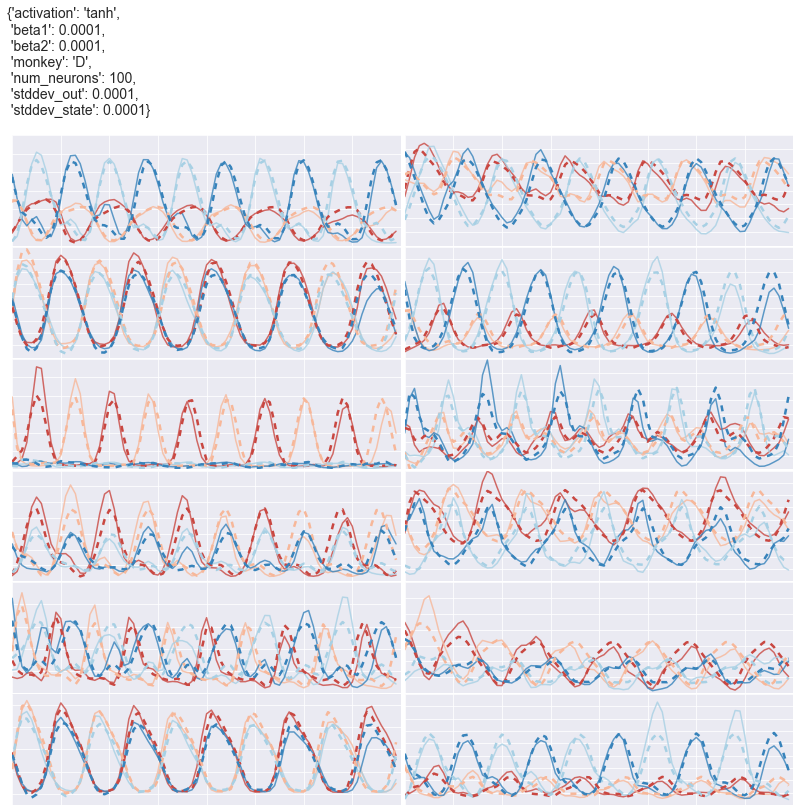

In [256]:
rows = 6
cols = 2

with sns.color_palette(n_colors=4):
    f, ax = plt.subplots(rows,cols, figsize=(14, 12), sharex=True, sharey=False,
                         subplot_kw={'xticklabels':[], 'yticklabels':[]},
                         gridspec_kw={'wspace':0.01, 'hspace':0.01})
    for i in range(rows):
        for j in range(cols):
            muscle = np.ravel_multi_index((i,j), (rows,cols))
            ax[i,j].plot(emg[:,:,muscle], linewidth=1.5, alpha=.8)
            ax[i,j].plot(y[:,:,muscle],'--',linewidth=2.5, alpha=1)
            #ax[i,j].set_title('muscle '+str(muscle))
f.suptitle(pp.pformat(cur_params), fontsize=14, x=0.12, y=0.92, verticalalignment='bottom', horizontalalignment='left')
plt.show()

## RNN neuron PC plots

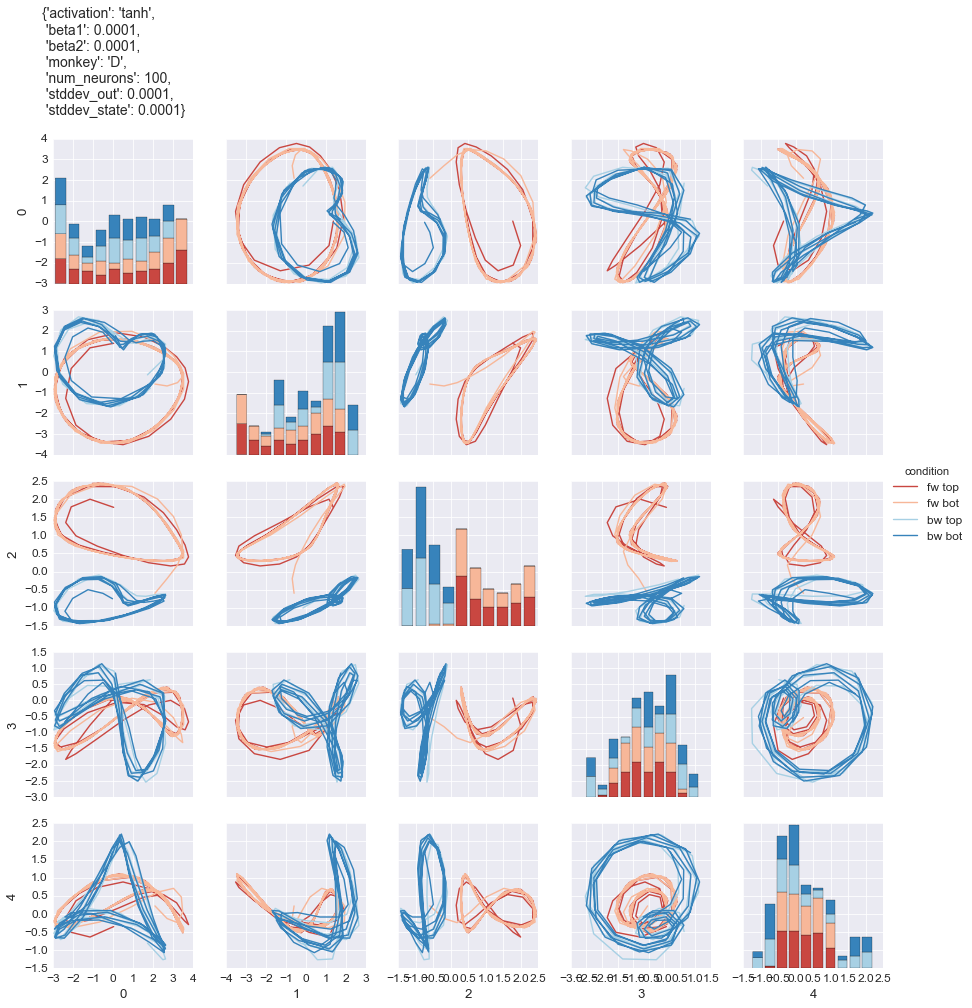

In [257]:
# plot PCs for the RNN state variable
pca_x = sk.decomposition.PCA(n_components=5)
pca_x.fit(np.concatenate([x[:,i,:] for i in range(4)]))
f = make_pairgrid([np.dot(x[:,i,:], pca_x.components_.T) for i in range(4)])
f.fig.suptitle(pp.pformat(cur_params), fontsize=14, x=0.05, y=1.0, verticalalignment='bottom', horizontalalignment='left')

## RNN activations

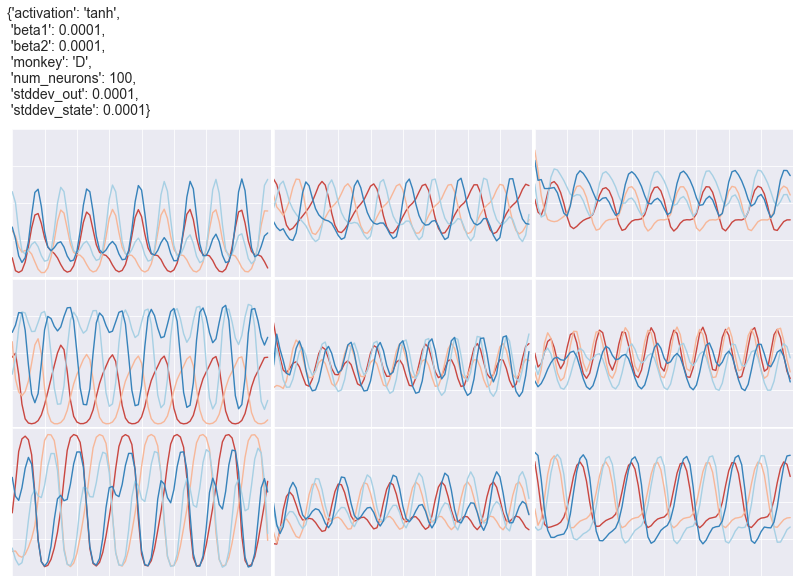

In [258]:
rows = 3
cols = 3
f, ax = plt.subplots(rows,cols, figsize=(14, 8), sharex=True, sharey=True,
                     subplot_kw={'ylim':[-1, 1], 'xticklabels':[], 'yticklabels':[]},
                     gridspec_kw={'wspace':0.01, 'hspace':0.01})

for i in range(rows):
    for j in range(cols):
        neuron = np.ravel_multi_index((i,j), (rows,cols))
        ax[i,j].plot(x[:,:,neuron])
        #ax[i,j].set_title(str(neuron))
f.suptitle(pp.pformat(cur_params), fontsize=14, x=0.12, y=0.92, verticalalignment='bottom', horizontalalignment='left')
plt.show()

## curvature plot

In [261]:
m1_k = np.zeros(m1.shape[:-1])
x_k = np.zeros(x_n.shape[:-1])
emg_k = np.zeros(emg.shape[:-1])
for c in range(4):
    m1_k[:,c] = get_curvature(m1[:,c,:])
    emg_k[:,c] = get_curvature(emg[:,c,:])
    x_k[:,c] = get_curvature(x[:,c,:])

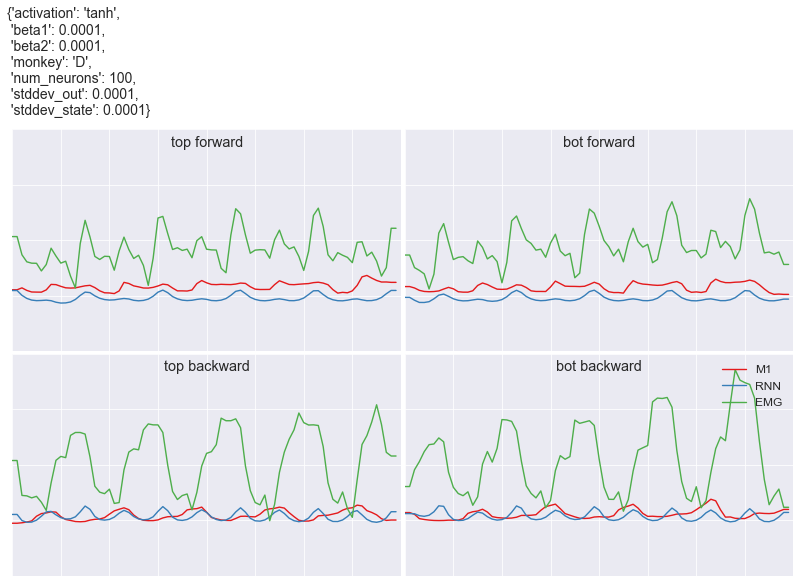

In [284]:
with sns.color_palette('Set1'):
    f, ax = plt.subplots(2,2, figsize=(14, 8), sharex=True, sharey=True,
                         subplot_kw={'ylim':[0, 2], 'xticklabels':[], 'yticklabels':[]},
                         gridspec_kw={'wspace':0.01, 'hspace':0.01})
    ax[0,0].plot(m1_k[:,0])
    ax[0,0].plot(x_k[:,0])
    ax[0,0].plot(emg_k[:,0])
    ax[0,0].set_title('top forward', y=0.9)
    
    ax[0,1].plot(m1_k[:,1])
    ax[0,1].plot(x_k[:,1])
    ax[0,1].plot(emg_k[:,1])
    ax[0,1].set_title('bot forward', y=0.9)
    
    ax[1,0].plot(m1_k[:,2])
    ax[1,0].plot(x_k[:,2])
    ax[1,0].plot(emg_k[:,2])
    ax[1,0].set_title('top backward', y=0.9)

    ax[1,1].plot(m1_k[:,3])
    ax[1,1].plot(x_k[:,3])
    ax[1,1].plot(emg_k[:,3])
    ax[1,1].set_title('bot backward', y=0.9)
    ax[1,1].legend(iter(ax[1,1].get_children()[:3]), ('M1', 'RNN', 'EMG'))

    f.suptitle(pp.pformat(cur_params), fontsize=14, x=0.12, y=0.92, verticalalignment='bottom', horizontalalignment='left')
plt.show()

### Load TF model

In [273]:
TF_PATH = RUN+'tfsaves/'+str(sim)
tf.reset_default_graph()
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(TF_PATH+'.meta')
    new_saver.restore(sess, TF_PATH)
    Mat = sess.run([v for v in tf.all_variables() if v.name == 'RNN/BasicRNNCellNoise/Linear/Matrix:0'])[0]
    A = Mat[2:]
    B = Mat[:2]

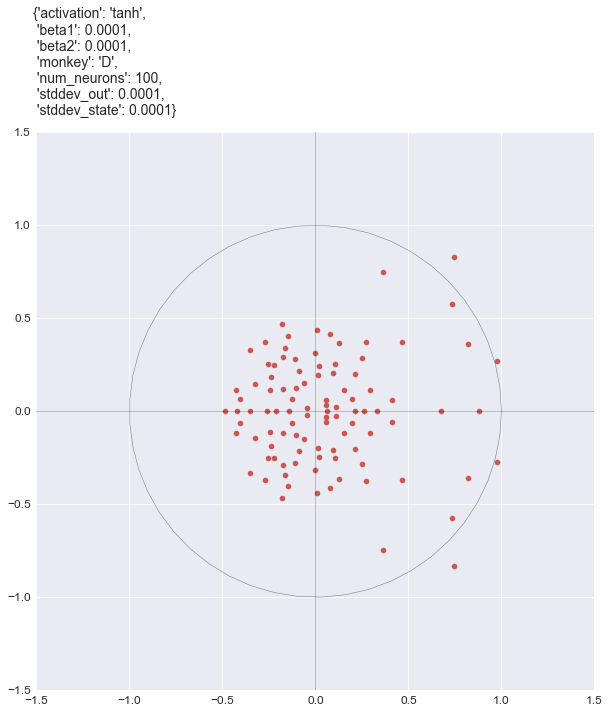

In [275]:
f = plot_eigs(A)
f.suptitle(pp.pformat(cur_params), fontsize=14, x=0.12, y=0.92, verticalalignment='bottom', horizontalalignment='left')
